<a href="https://colab.research.google.com/github/myozaw5288/git/blob/master/KP(MMO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

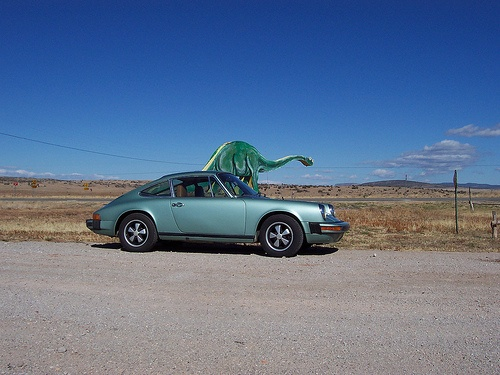

In [1]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/img_data/car/car-0004.jpg')

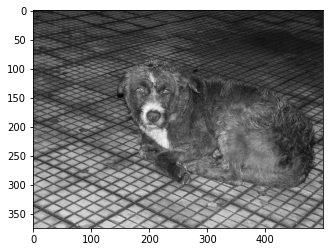

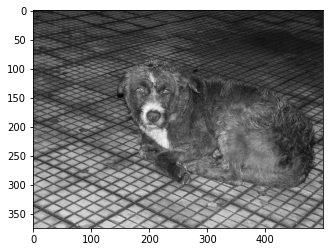

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATADIR='/content/drive/MyDrive/img_data'
CATEGORIES=['dog','dog']
for category in CATEGORIES:
  path=os.path.join(DATADIR,category)

  for category in CATEGORIES:
    path = os.path.join(DATADIR,category) # path to nerd or beetle
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img) , 0)
      plt.imshow(img_array, cmap="gray")
      plt.show()
        
      break
    break 

In [3]:
print(img_array)

[[ 50  62  62 ...  33  32  33]
 [ 39  36  41 ...  36  38  40]
 [ 32  23  15 ...  31  27  26]
 ...
 [191 184 191 ... 165 166 172]
 [183 193 192 ... 171 163 171]
 [147 174 192 ... 163 166 166]]


In [4]:
print(img_array.shape)

(375, 500)


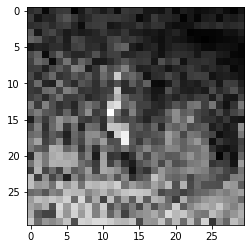

In [5]:
img_size=30
new_array=cv2.resize(img_array,(img_size,img_size))
plt.imshow(new_array,cmap='gray')

In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 109 kB 5.1 MB/s 


In [35]:
classifier_url ="https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [36]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper = np.array(grace_hopper)/255.0

result = classifier.predict(grace_hopper[np.newaxis, ...])

predicted_class = np.argmax(result[0], axis=-1)

73728/61306 [====================================] - 0s 0us/step


In [37]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


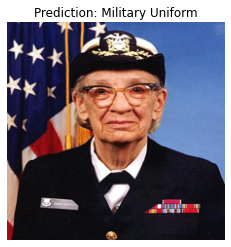

In [38]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [39]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [40]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [41]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [42]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


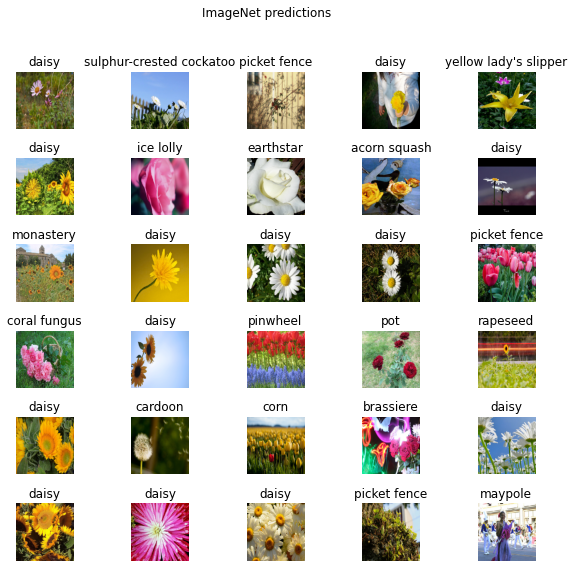

In [43]:
result_batch = classifier.predict(image_batch)
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [48]:
feature_extractor_url = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)  # (32, 1280)
feature_extractor_layer.trainable = False

(32, 1280)


In [50]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

In [51]:
predictions = model(image_batch)

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [53]:
predictions.shape

TensorShape([32, 5])

In [54]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [55]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [56]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/2
115/115 [==============================] - 105s 884ms/step - loss: 0.3270 - acc: 0.9062
Epoch 2/2
115/115 [==============================] - 101s 878ms/step - loss: 0.2273 - acc: 0.9375


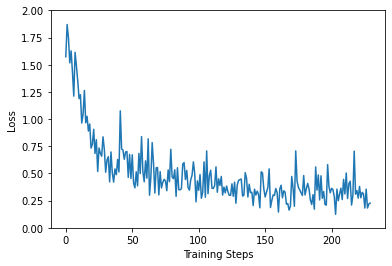

In [59]:
# Display of changes in loss value during training
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

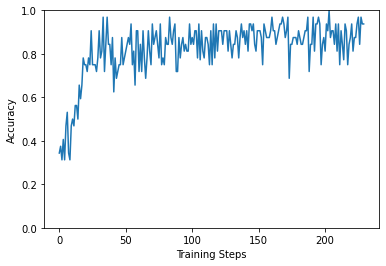

In [60]:
# Change in precision
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [64]:
# Test results
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [65]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

In [66]:
label_id=np.argmax(label_batch,axis=-1)

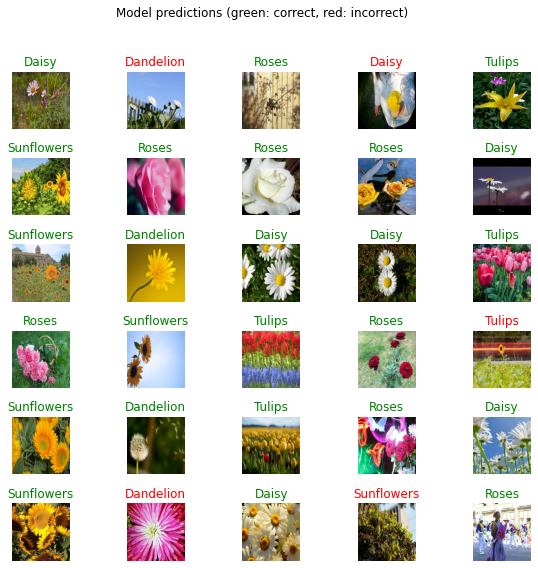

In [67]:
# Visualization
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

Export your model

In [68]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1636810854/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1636810854/assets


'/tmp/saved_models/1636810854'

In [69]:
# Download
reloaded = tf.keras.models.load_model(export_path)

In [70]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)


In [71]:
abs(reloaded_result_batch - result_batch).max()

0.0